# Modeling Advection-Dominated Flows with Space-Local Reduced-Order Models

In [1]:
using local_POD_overlap

using Plots
using LaTeXStrings
using ProgressBars

import LinearAlgebra.eigvals 
using Statistics


# Simulation

In this work we are concerned with developing a reduced-order model for the linear advection equation. This equation is chosen as it exhibits similar difficulties as the incompressible Navier-Stokes equations when applying model reduction. We consider a scalar solution $u(x,t)$ to the linear advection equation
\begin{equation}\label{eq:advection_equation}
    \frac{\partial u}{\partial t} = - c \frac{\partial u}{\partial x},
\end{equation}
with initial condition $u(x,0) = \exp(-50(x - \frac{1}{4}\pi)^2)$ and constant $c=1$. We employ a periodic domain $\Omega = [0,2 \pi)$ such that we do not require boundary conditions (BCs).

To approximate the spatial derivative we use a central difference approximation:
\begin{equation}\label{eq:stencil}
    \frac{\partial u}{\partial x}|_{x_i} \approx \frac{\text{u}_{i+1}-\text{u}_{i-1}}{2h}.
\end{equation}
This leads to the following semi-discrete system of equations
\begin{equation}\label{eq:semi-discrete}
    \frac{\text{d}\mathbf{u}}{\text{d}t} = -c \mathbf{D}\mathbf{u},
\end{equation}
where the linear operator $\mathbf{D} \in \mathbb{R}^{N \times N}$ is skew-symmetric. For the time integration we use a classic RK4 scheme.

In [2]:

N = 1000


omega = 2*pi

x = (collect(1:N).-1/2)/N .* omega

D1 = gen_stencil(size(x)[1],[-1,0,1]./(2*(x[2]-x[1])),[-1,0,1])
f(u,x,t,D1 = D1) = -D1*u 
#############################
dt = 0.01 # time-step size
T = 2 # simulate until t=T
save_every = 1 # save reference data every 10 time-steps
samples = 1 # number of simulations (we only do a single simulation, but you can also do multiple simulations 
# with e.g. different initial conditions)


us = Array{Float64}(undef, size(x)[1],0) # Store solution vectors
ts = Array{Float64}(undef,  1,0) # Store time
Fs = Array{Float64}(undef, size(x)[1],0) # Store forcing



for sample in tqdm(1:samples) # Checking if sample is even to determine type of BCs
    
    # Simulate the flow

    u0 = exp.(-50 .* (x .- 1/4*pi) .^2) # Initial condition
    u,du,t = simulation(u0,x,dt,T,  f  ,F = 0,save_every = save_every) # simulate
    
    us = [us ;; u]
    ts = [ts t]
end


0.0%┣                                                ┫ 0/1 [00:01<00:-1, -1s/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:02<Inf:Inf, InfGs/it]
100.0%┣██████████████████████████████████████████┫ 1/1 [00:02<Inf:Inf, InfGs/it]


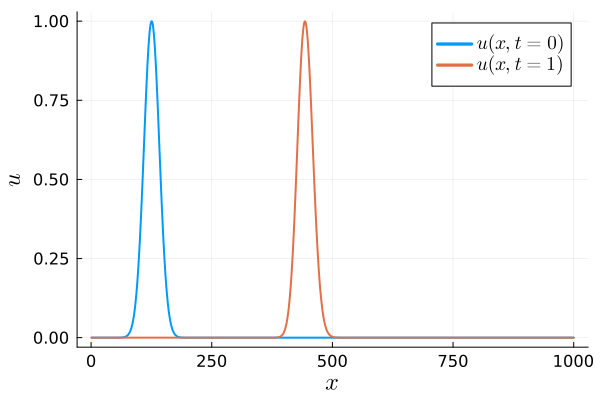

In [3]:
plot(us[:,1],linewidth = 2,label = L"u(x,t=0)",xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(16), 
    legendfont=font(13))
plot!(us[:,end],linewidth = 2,label = L"u(x,t=1)")
xlabel!(L"x")
ylabel!(L"u")

# Split data into training and validation data

In [4]:
train_data = us[:,1:100] # First half of the simulation
val_data = us[:,100:200] # Second half of the simulation


1000×101 Matrix{Float64}:
  4.61315e-18  -3.98889e-17  -1.11908e-16  …   4.84237e-17  -3.52791e-17
  1.9254e-17    8.69407e-17   1.54553e-16      3.47986e-18   9.86216e-17
 -6.13707e-17  -1.35751e-16  -1.74873e-16     -6.80187e-17  -1.444e-16
  1.12228e-16   1.69841e-16   1.61622e-16      1.23893e-16   1.61429e-16
 -1.56521e-16  -1.75136e-16  -1.12349e-16     -1.55451e-16  -1.49578e-16
  1.78784e-16   1.44002e-16   3.49695e-17  …   1.573e-16     1.17936e-16
 -1.67137e-16  -7.82026e-17   5.17375e-17     -1.34444e-16  -8.00241e-17
  1.1716e-16   -8.13401e-18  -1.22319e-16      9.86644e-17   4.85028e-17
 -3.72072e-17   9.05352e-17   1.55034e-16     -6.3294e-17   -3.14614e-17
 -5.11463e-17  -1.43996e-16  -1.415e-16        3.87195e-17   3.11725e-17
  1.21702e-16   1.53638e-16   8.87686e-17  …  -3.00364e-17  -4.49256e-17
 -1.54468e-16  -1.18843e-16  -1.58085e-17      3.69794e-17   6.6868e-17
  1.4122e-16    5.25633e-17  -5.16674e-17     -5.52996e-17  -8.98621e-17
  ⋮                         

# $k_i(x)$ functions

Kernels used to split the solution between the different subdomains in the LO-POD method.

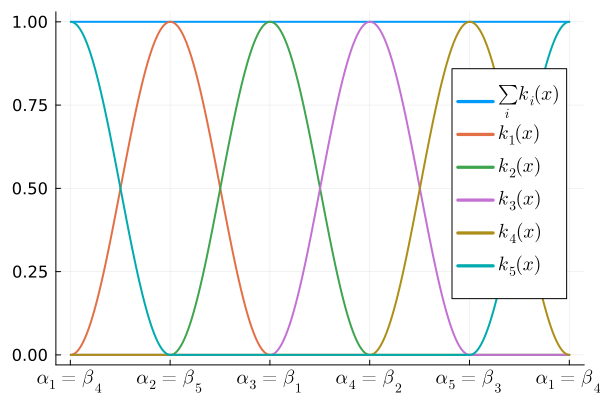

In [5]:
I = 5 # number of subdomains
J = Int(N/I) # grid points withing the subdomains

overlap = 1 # overlap parameter, leave this on 1 for the results in the paper
q = 1



k = kernel((overlap+1)*J)
offset = 0
kernels = zeros(N,(I)*q)
total_modes = size(kernels)[2]
width = size(k)[1]

for i in 1:I
    kernels[1:width,1:q] = k
    kernels = circshift(kernels,(J,q))
end

plot(sum(kernels,dims = 2),linewidth = 2,label = L"\sum_i k_i(x)",xtickfont=font(13), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),legend= :right)


plot!(kernels,linewidth = 2,label = [L"k_1(x)" L"k_2(x)" L"k_3(x)" L"k_4(x)" L"k_5(x)"],xticks=([0,200,400,600,800,1000],[L"\alpha_1=\beta_4",L"\alpha_2=\beta_5",L"\alpha_3 = \beta_1",L"\alpha_4 = \beta_2",L"\alpha_5 = \beta_3",L"\alpha_1 = \beta_4"]),right_margin = 2Plots.mm)
savefig("plots/k.pdf")
plot!()

# Find best parameters for local POD

Consider again $\mathbf{u}$, the state vector of the full-order model, and $\boldsymbol{\Phi} \in \mathbb{R}^{N \times r}$ a reduced basis where $r<N$, obtained from either G-POD, L-POD, or LO-POD. The corresponding `Gram' matrix $\mathbf{S} \in \mathbb{R}^{r\times r}$ of this basis is computed as 
\begin{equation}
    \mathbf{S} = \boldsymbol{\Phi}^T \boldsymbol{\Phi}.
\end{equation}
We can project $\mathbf{u}$ onto the subspace spanned by the POD basis as
\begin{equation}\label{eq:projector}
    \mathbf{u}_r = \underbrace{\boldsymbol{\Phi} \mathbf{S}^{-1}\boldsymbol{\Phi}^T}_{=:\mathbf{P}} \mathbf{c}.
\end{equation}
Note that for both G-POD and L-POD computing the inverse of $\mathbf{S}$ is trivial, as it is simply identity. This comes from the fact that the basis is orthogonal. However, for LO-POD the basis is non-orthogonal, which makes computing its inverse less trivial. 
It is quite straightforward to see that $\mathbf{P}$ is a projection operator as $\mathbf{P}^2 = \mathbf{P}$.
The POD coefficient vector is obtained as
\begin{equation}\label{eq:POD_coefficient_vector}
    \mathbf{a} = \mathbf{S}^{-1}\boldsymbol{\Phi}^T\mathbf{c}.
\end{equation}

In [6]:
overlap = 1 # overlap parameter, leave this on 1 for the results in the paper


local_train_errs = []
overlap_train_errs = []


local_val_errs = []
overlap_val_errs = []

Is = [5,10,20,25,50] # Different values of I

for I in Is
    qs = collect(1:floor(Int,100/I))

    local_train_err = []
    overlap_train_err = []


    local_val_err = []
    overlap_val_err = []
    for q in qs

        local_POD = gen_ROM(x,train_data,f,r = q,I = I,localize = true,overlap = 0 ) # Generate L-POD ROM
        overlap_POD = gen_ROM(x,train_data,f,r = q,I = I,localize = true,overlap = overlap) # Generate LO-POD ROM

        # Compute projection error on training set
        push!(local_train_err,compute_L2(train_data - local_POD.P *train_data )) 
        push!(overlap_train_err,compute_L2((train_data - overlap_POD.P *train_data )))

        # Compute projection error on validation set
        push!(local_val_err,compute_L2((val_data - local_POD.P *val_data )))
        push!(overlap_val_err,compute_L2((val_data - overlap_POD.P *val_data )))
    end
    

    push!(local_train_errs,local_train_err)
    push!(overlap_train_errs,overlap_train_err)

    push!(local_val_errs,local_val_err)
    push!(overlap_val_errs,overlap_val_err)
    
    
end

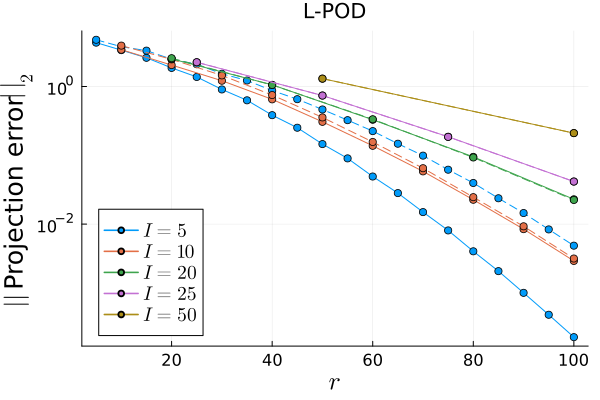

In [7]:
plot(yscale = :log, legend=:bottomleft,xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:size(Is)[1]
    I = Is[i]
    plot!(collect(1:size(local_train_errs[i])[1])*Is[i],local_train_errs[i],marker = true,label = L"I = %$I",color = i) 
    plot!(collect(1:size(local_val_errs[i])[1])*Is[i],local_val_errs[i],marker = true,label = false, linestyle = :dash,color = i) 
    
end
xlabel!(L"r")
ylabel!(L"||" *"Projection error"* L"||_2")
title!("L-POD")
savefig("plots/proj_local.pdf")

plot!()

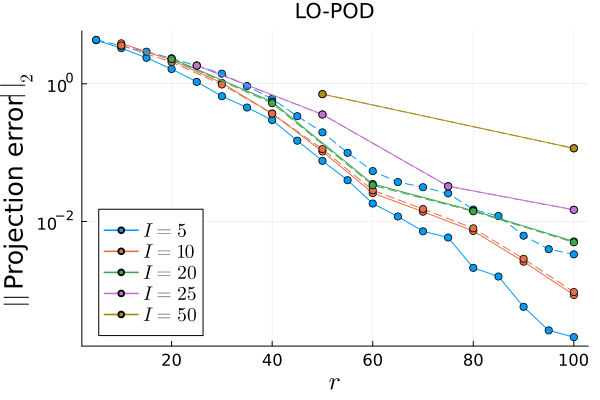

In [8]:
plot(yscale = :log, 
    legend=:bottomleft,xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:size(Is)[1]
    I = Is[i]
    plot!(collect(1:size(overlap_train_errs[i])[1])*Is[i],overlap_train_errs[i],marker = true,label = L"I = %$I",color = i) 
    plot!(collect(1:size(overlap_val_errs[i])[1])*Is[i],overlap_val_errs[i],marker = true,label = false, linestyle = :dash,color = i) 
    
end
xlabel!(L"r")
ylabel!(L"||" *"Projection error"* L"||_2")
title!("LO-POD")
savefig("plots/proj_overlap.pdf")
plot!()

# Compare against global POD

In [9]:
I = 10 # Choose I = 10 based on previous results
overlap = 1 # Set overlap parameter to one (gives the same result as in the paper)


local_train_err = []
overlap_train_err = []
qs = collect(1:10)


local_val_err = []
overlap_val_err = []



for q in qs
    
    
    local_POD = gen_ROM(x,train_data,f,r = q,I = I,localize = true,overlap = 0 ) # Generate L-POD ROM
    overlap_POD = gen_ROM(x,train_data,f,r = q,I = I,localize = true,overlap = overlap) # Generate LO-POD ROM
    
    
    
    # Compute projection error on training set
    push!(local_train_err,compute_L2((train_data - local_POD.P *train_data )))
    push!(overlap_train_err,compute_L2((train_data - overlap_POD.P *train_data )))
    
    # Compute projection error on validation set
    push!(local_val_err,compute_L2((val_data - local_POD.P *val_data )))
    push!(overlap_val_err,compute_L2((val_data - overlap_POD.P *val_data )))
    
end

global_val_err = []
global_train_err = []

global_nonzero = []

glob_rs = collect(1:100)

for r in glob_rs 
    global_POD = gen_ROM(x,train_data,f,r = r,I = 1,localize = false  ) # Generate G-POD ROM
    
    push!(global_train_err,compute_L2((train_data - global_POD.P *train_data) ))
    
    push!(global_val_err,compute_L2((val_data - global_POD.P *val_data) ))
end

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584


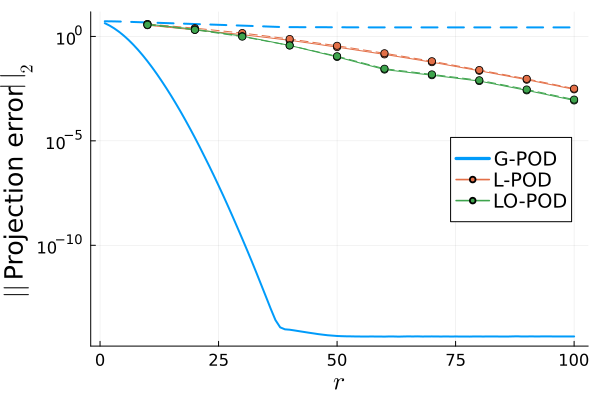

In [10]:
plot(glob_rs, global_train_err,linewidth = 2,label = "G-POD",yscale = :log, 
    xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),color = 1,legend=:right)
plot!(glob_rs, global_val_err,linewidth = 2,linestyle = :dash,color = 1,label = false)
plot!(qs * I, local_train_err,marker = true,label = "L-POD",color = 2)
plot!(qs * I, local_val_err,marker = true,linestyle = :dash,color = 2,label = false)
plot!(qs * I, overlap_train_err,marker = true,label = "LO-POD",color = 3)
plot!(qs * I, overlap_val_err,marker = true,linestyle = :dash,color = 3,label = false)
xlabel!(L"r")
ylabel!(L"||" *"Projection error"* L"||_2")
savefig("plots/projection.pdf")
plot!()

# Plot POD bases

In [34]:
I = 10
q = 6
overlap =1

global_POD = gen_ROM(x,train_data,f,r = I*q,I = 1,localize = false  )
local_POD = gen_ROM(x,train_data,f,r = q,I = I,localize = true,overlap = 0 )
overlap_POD = gen_ROM(x,train_data,f,r = q,I = I,localize = true,overlap = overlap)
0


0

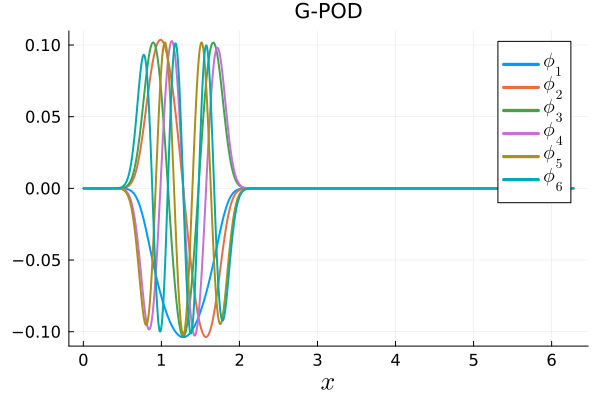

In [35]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:q
    plot!(x,global_POD.basis[:,i],linewidth = 2,label = L"\phi_{%$i}")
end
xlabel!(L"x")
title!("G-POD")
savefig("plots/basis_global.pdf")
plot!()



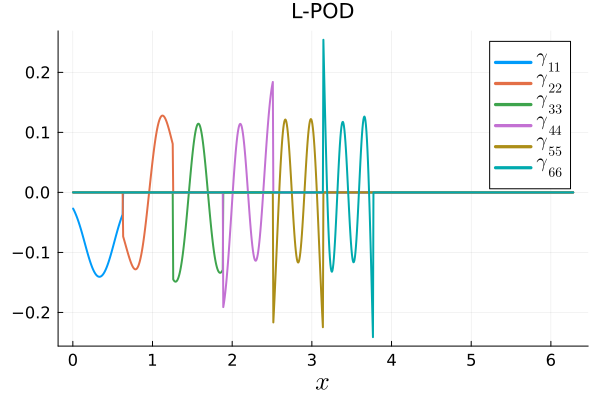

In [36]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:q
    plot!(x,local_POD.basis[:,1+(i-1)*(q+1)],linewidth = 2,label = L"\gamma_{%$i%$i}")
end
xlabel!(L"x")
title!("L-POD")
savefig("plots/basis_local.pdf")
plot!()



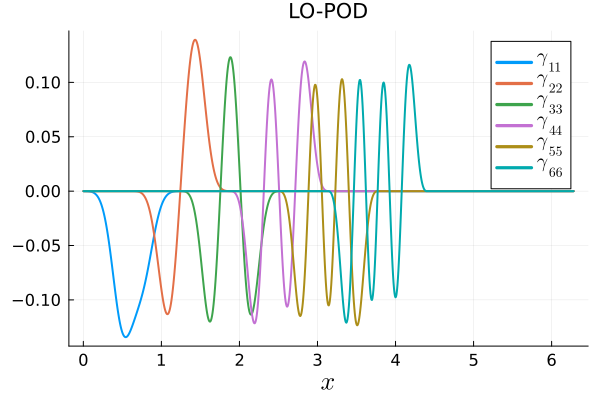

In [37]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
for i in 1:q
    plot!(x,overlap_POD.basis[:,1+(i-1)*(q+1)],linewidth = 2,label = L"\gamma_{%$i%$i}")
end
xlabel!(L"x")
title!("LO-POD")
savefig("plots/basis_overlap.pdf")
plot!()

# Plot reconstruction of traveling wave for different POD methods

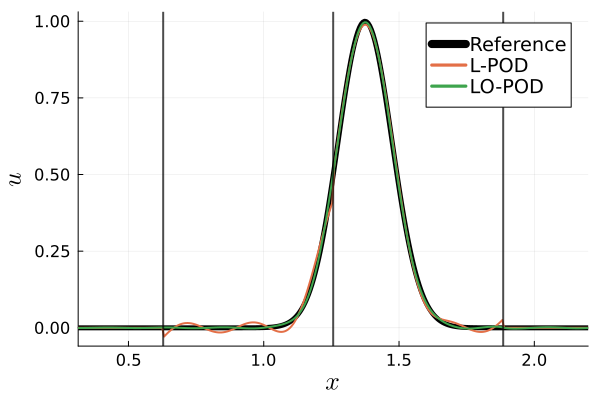

In [15]:
index = 60
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
plot!(x,train_data[:,index] ,linewidth = 5,color = "black", label = "Reference")
plot!(x,local_POD.P*train_data[:,index] ,linewidth = 2,color = 2,label = "L-POD")
plot!(x,overlap_POD.P*train_data[:,index] ,linewidth = 2,color = 3, label = "LO-POD")
xlabel!(L"x")
ylabel!(L"u")
xlims!(0.05*2*pi,0.35*2*pi)
vline!([0.1*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([0.2*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([0.3*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
#plot!(x,train_data[:,index],linewidth = 2)
savefig("plots/discontinuity.pdf")
plot!()

# Plot finite difference basis for Gaussian function

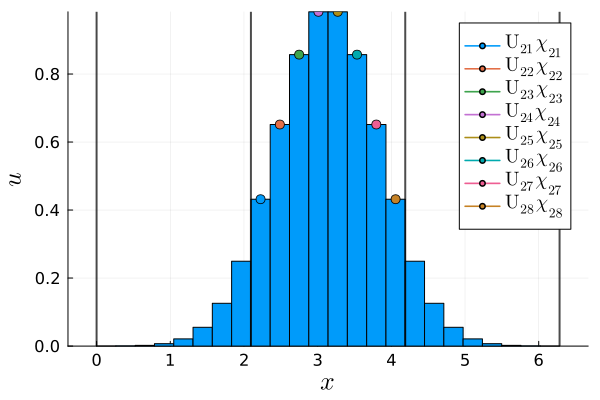

In [16]:
n = 24
y = (collect(1:n).-1/2)/n .* omega # y
u = exp.(-(y .- pi) .^ 2) # u(y)


plot(bar(y,u,label = false, bar_width = omega/n),xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
vline!([1/3*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([2/3*2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([0], color = "black",linewidth = 2,alpha = 0.7,label = false)
vline!([2*pi], color = "black",linewidth = 2,alpha = 0.7,label = false)
xlabel!(L"x")
ylabel!(L"u")
#plot!(bar(y,u))
for i in 9:16
    index = i-8
    plot!([y[i],],[u[i],],marker = true,markersize = 5,color = i-8,label = L"\mathrm{U}_{2%$index}\chi_{2%$index}")
end

savefig("plots/local_basis.pdf")
plot!()


# Simulation using the ROMs

Having obtained a reduced basis $\boldsymbol{\Phi}^{N\times r}$, we construct a ROM for the advection equation as follows: We define the residual $\mathbf{r} \in \mathbb{R}^N$ as 
\begin{equation}
    \mathbf{r}(\mathbf{u}_r) := \frac{\text{d}\mathbf{u}_r}{\text{d}t}+c\mathbf{D}\mathbf{u}_r \neq \mathbf{0},
\end{equation}
where we replaced $\mathbf{u}$ by the POD approximation $\mathbf{u}_r = \boldsymbol{\Phi} \mathbf{a}$.
Next, we carry out the Galerkin projection of the residual on the POD basis and set this to zero:
\begin{equation}
    \mathbf{S}^{-1}\boldsymbol{\Phi}^T\mathbf{r}(\mathbf{u}_r) = \mathbf{0}.
\end{equation}
This ensures the residual is orthogonal to the basis. 
This results in the following ROM:
\begin{equation}\label{eq:ROM}
     \frac{\text{d}\mathbf{a}^\text{ROM}}{\text{d}t} := -c\mathbf{S}^{-1}\mathbf{A}\mathbf{a}^\text{ROM},
\end{equation}
where the ROM operator $\mathbf{A} \in \mathbb{R}^{r\times r}$ is defined as 
\begin{equation}
   \mathbf{A} := \boldsymbol{\Phi}^T \mathbf{D}\boldsymbol{\Phi}. 
\end{equation}
Note that we introduced $\mathbf{a}^\text{ROM}$ here as the POD state vector predicted by ROM. This is typically not equal to the true $\mathbf{a}$.

## Simulation using $\Delta t = 0.01$

In [17]:
#############################
dt = 0.01 # time-step size
T = 5  #simulate until t=T
save_every = 1 # save reference data every 10 time-steps
#samples = 1 # number of simulations



results = []
energy_error = []

ROMs = [global_POD,local_POD,overlap_POD]

u0 = exp.(-50 .* (1/4*pi .- x) .^2)

for i in ROMs
    
    
    a0 = i.S_inv * i.basis'*u0

    a,da,t = simulation(a0,zeros(size(i.S)[1]),dt,T,  i.f  ,F = 0,save_every = save_every) # simulate


    # Save quantities
    u_r = i.basis * a
    push!(energy_error,((x[2]-x[1])* sum(u_r .* (i.basis * i.f(a,x,0)),dims = 1)))
    push!(results,u_r)
    
end

## reference simulation
ref_u,du,t = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every) # simulate
push!(results,ref_u)
push!(energy_error, ((x[2]-x[1])* sum(ref_u .* f(ref_u,x,0),dims = 1)))

0

0

## Simulation using $\Delta t = 0.05$

In [18]:
#############################
dt = 0.05 # time-step size
T = 5  #simulate until t=T
save_every = 1 # save reference data every 10 time-steps
#samples = 1 # number of simulations


larger_results = []


u0 = exp.(-50 .* (1/4*pi .- x) .^2)
#u0 = (1 .< x) .* (x .< 2)
for i in ROMs
    
    
    a0 = i.S_inv * i.basis'*u0

    a,da,t_larger = simulation(a0,zeros(size(i.S)[1]),dt,T,  i.f  ,F = 0,save_every = save_every) # simulate


    # Save quantities
    u_r = i.basis * a
    push!(larger_results,u_r)
    
end

## reference simulation
ref_u,du,t_larger = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every) # simulate
push!(larger_results,ref_u)


0

0

## Visualization of the simulations

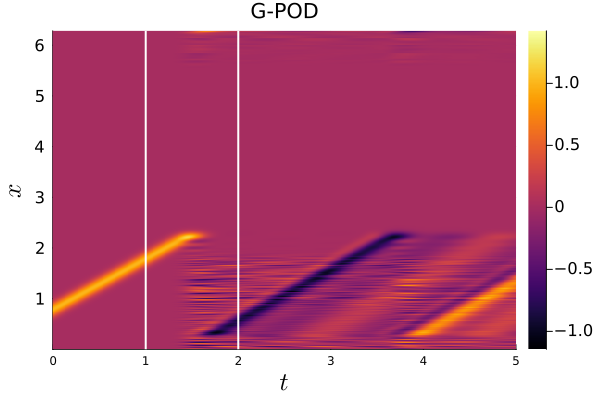

In [19]:
heatmap(t'[1:end],x,results[1], 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),right_margin = 4Plots.mm)



vline!([1],color = :white, linewidth = 2,label = false)
vline!([2],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("G-POD")
savefig("plots/G_POD.pdf")
plot!()

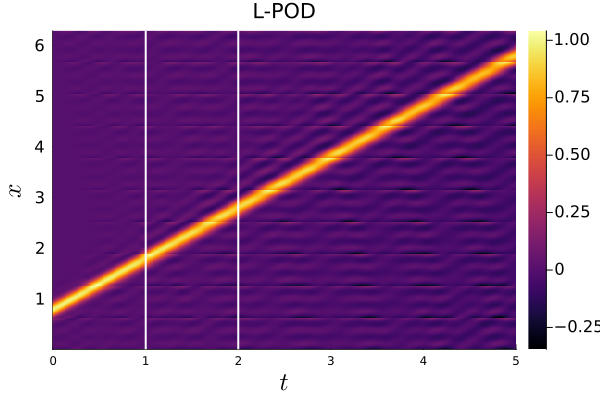

In [20]:
heatmap(t'[1:end],x,results[2],ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),right_margin = 4Plots.mm)

vline!([1],color = :white, linewidth = 2,label = false)
vline!([2],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("L-POD")
savefig("plots/L_POD.pdf")
plot!()

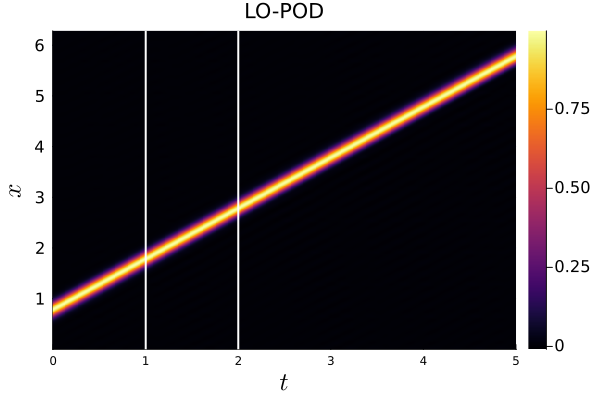

In [21]:
heatmap(t'[1:end],x,results[3],ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),right_margin = 4Plots.mm)

vline!([1],color = :white, linewidth = 2,label = false)
vline!([2],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("LO-POD")
savefig("plots/LO_POD.pdf")
plot!()

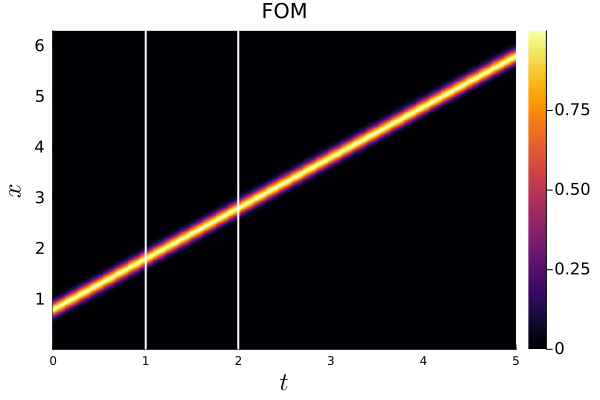

In [22]:
heatmap(t'[1:end],x,results[4], ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),right_margin = 4Plots.mm)

vline!([1],color = :white, linewidth = 2,label = false)
vline!([2],color = :white, linewidth = 2,label = false)
xlabel!(L"t")
ylabel!(L"x")
title!("FOM")

savefig("plots/reference.pdf")
plot!()

## Solution error

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584


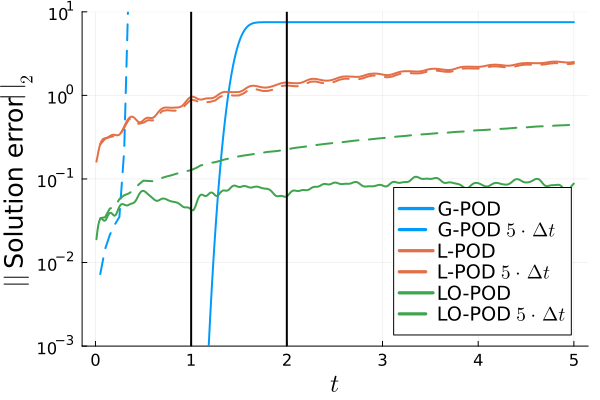

In [23]:
plot(ylimits = (1e-3,10.),xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),legend = :bottomright)
labels = ["G-POD","L-POD","LO-POD"]
for i in 1:size(ROMs)[1]
    plot!(t'[2:end],compute_L2(( results[4] - results[i]),average = false)'[2:end],yscale = :log,label = labels[i],linewidth = 2,color = i)
    plot!(t_larger'[2:end],compute_L2((larger_results[4] - larger_results[i]),average = false)'[2:end],yscale = :log,label = labels[i] * " " * L"5 \cdot \Delta t",linewidth = 2,color = i,linestyle = :dash)
end
vline!([1],linewidth = 2,color = :black,label =false)
vline!([2],linewidth = 2,color = :black,label =false)
plot!()
xlabel!(L"t")

ylabel!(L"||" *"Solution error"* L"||_2")
savefig("plots/error_trajectory.pdf")
plot!()

## Change in energy

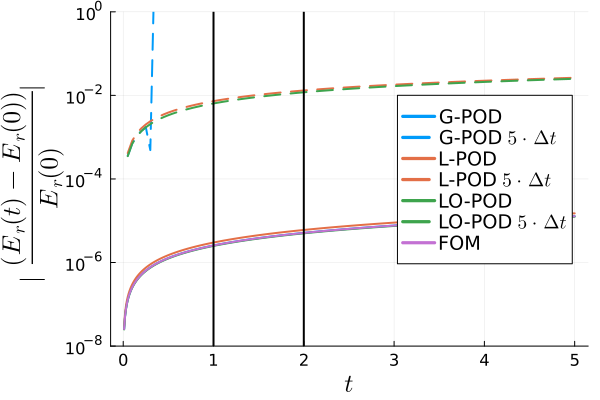

In [24]:
plot(yscale = :log,ylimits = (1e-8,1.),xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),left_margin = 3Plots.mm,legend = :right)

labels = ["G-POD","L-POD","LO-POD","FOM"]
for i in 1:size(ROMs)[1]+1
    plot!(t'[2:end],abs.((sum((results[i]).^2,dims = 1)'[2:end] .- sum((results[i]).^2,dims = 1)'[1])/(sum((results[i]).^2,dims = 1)'[1])),label = labels[i],linewidth = 2,color = i)
    if i != 4
        plot!(t_larger'[2:end],abs.((sum((larger_results[i]).^2,dims = 1)'[2:end] .- sum((larger_results[i]).^2,dims = 1)'[1])/(sum((larger_results[i]).^2,dims = 1)'[1])),label = labels[i]* " " * L"5 \cdot \Delta t",linewidth = 2,linestyle = :dash,color = i)
    end
end
vline!([1],linewidth = 2,color = :black,label = false)
vline!([2],linewidth = 2,color = :black,label =false)
xlabel!(L"t")
ylabel!(L"|\frac{(E_r(t)-E_r(0))}{E_r(0)}|")
savefig("plots/energy_trajectory.pdf")
plot!()

## Instantanious chang in energy

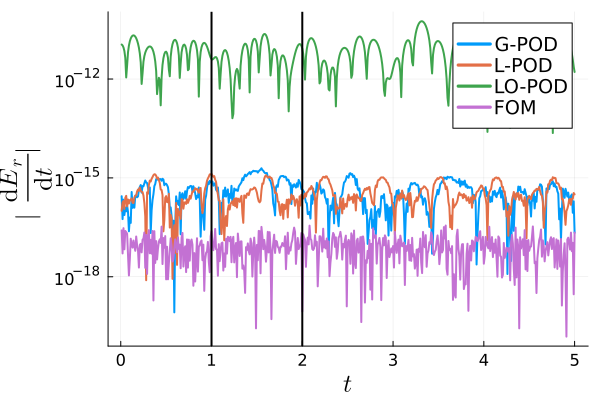

In [25]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13),left_margin = 2Plots.mm,yscale = :log)
labels = ["G-POD","L-POD","LO-POD","FOM"]
for i in 1:size(ROMs)[1]+1
    plot!(t'[2:end],abs.(energy_error[i][2:end]),label = labels[i],linewidth = 2)
end
vline!([1],linewidth = 2,color = :black,label = false)
vline!([2],linewidth = 2,color = :black,label =false)
plot!()
xlabel!(L"t")
ylabel!(L"|\frac{\mathrm{d}E_r}{\mathrm{d}t}|")
savefig("plots/change_in_energy_trajectory.pdf")
plot!()

## Eigenvalues of the ROM operator

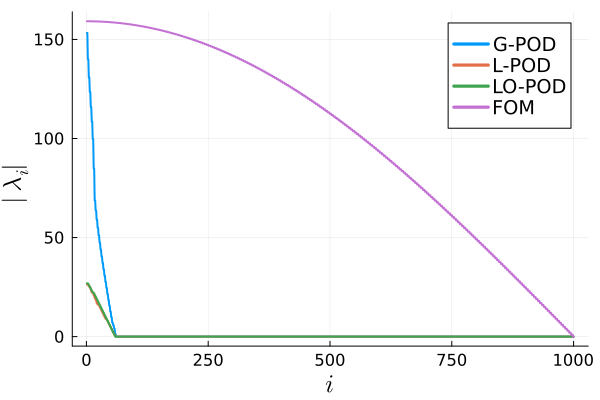

In [26]:
plot(xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))

plot!(reverse(sort(real.(abs.(eigvals(global_POD.p_A))))),label = "G-POD",linewidth = 2)
plot!(reverse(sort(real.(abs.(eigvals(local_POD.p_A))))),label = "L-POD",linewidth = 2)
plot!(reverse(sort(real.(abs.(eigvals(overlap_POD.p_A))))),label = "LO-POD",linewidth = 2)
plot!(reverse(sort(real.(abs.(eigvals(Matrix(D1)))))),label = "FOM",linewidth = 2)
xlabel!(L"i")
ylabel!(L"|\lambda_i|")
savefig("plots/eigenvalues.pdf")
plot!()

# Convergence

## Run finite difference simulations  

In [27]:
_Ns_ = 10*collect(1:99) # Grid resolutions to consider

fd_error = []
fd_eval_times = []

T = 5
dt = 0.01 # time-step size

u0 = exp.(-50 .* (1/4*pi .- x) .^2)
ref_u,du,t = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every)

samples = 10 # Repeat experiment 10 times to determine computation time

for _N_ in tqdm(_Ns_)


    _x_ = (collect(1:_N_).-1/2)/_N_ .* omega

    _D1_ = gen_stencil(size(_x_)[1],[-1,0,1]./(2*(_x_[2]-_x_[1])),[-1,0,1]) # Operator for the new grid resolution
    _f_(u,x,t,v = 0.0,D1 = _D1_) = -D1*u 
    

    M = interpolation_matrix(x,_x_)

    #############################
    
    u0 = exp.(-50 .* (1/4*pi .- _x_) .^2) # initial condition
    u = 0 
    du = 0
    t = 0
    eval_times = []
    for i in 1:samples
        eval_time = @timed begin # evaluate the computation time
        u,du,t = simulation(u0,_x_,dt,T,  _f_  ,F = 0,save_every = save_every) # simulate
        end
        if i > 1 # Dont record time for the first run to account for compilation time
            push!(eval_times,eval_time[2])
        end
    end
    
    # Save quantities
    push!(fd_error,compute_L2((ref_u -M* u)))
    push!(fd_eval_times,mean(eval_times))

end


0.0%┣                                               ┫ 0/99 [00:00<00:00, -0s/it]
1.0%┣▍                                          ┫ 1/99 [00:00<Inf:Inf, InfGs/it]
3.0%┣█▌                                              ┫ 3/99 [00:01<00:24, 4it/s]
4.0%┣██                                              ┫ 4/99 [00:01<00:18, 5it/s]
5.1%┣██▍                                             ┫ 5/99 [00:01<00:14, 6it/s]
6.1%┣███                                             ┫ 6/99 [00:01<00:13, 7it/s]
7.1%┣███▍                                            ┫ 7/99 [00:01<00:12, 8it/s]
8.1%┣███▉                                            ┫ 8/99 [00:01<00:11, 8it/s]
9.1%┣████▍                                           ┫ 9/99 [00:01<00:11, 8it/s]
10.1%┣████▋                                         ┫ 10/99 [00:01<00:11, 8it/s]
11.1%┣█████▏                                        ┫ 11/99 [00:01<00:11, 8it/s]
12.1%┣█████▋                                        ┫ 12/99 [00:01<00:11, 8it/s]
13.1%┣██████                

## Run ROM simulations for different amounts of degrees of freedom

In [28]:
qs = collect(1:10)
I = 10
overlap =1

# Arrays to store results in

global_error = []
global_eval_times = []
global_sparsity = []

local_error = []
local_eval_times = []
local_sparsity = []


overlap_error = []
overlap_eval_times = []
overlap_sparsity = []


u0 = exp.(-50 .* (1/4*pi .- x) .^2) # Initial condition

# Reference simulation
ref_u,du,t = simulation(u0,x,0.01,T,  f  ,F = 0,save_every = Int(dt/0.01)*save_every)

samples = 10

for q in tqdm(qs)
    
    # generate ROMs
    global_POD = gen_ROM(x,train_data,f,r = q*I,I = 1,localize = false,overlap = 0 )
    local_POD = gen_ROM(x,train_data,f,r = q,I = I,localize = true,overlap = 0 )
    overlap_POD = gen_ROM(x,train_data,f,r = q,I = I,localize = true,overlap = overlap)


    #############################
    dt = 0.01 # time-step size
    T = 5  #simulate until t=T
    save_every = 1 # save reference data every time step


    t = 0
    results = []
    energy_error = []

    ROMs = [global_POD,local_POD,overlap_POD]
    error = [global_error,local_error,overlap_error]
    eval_times = [global_eval_times,local_eval_times,overlap_eval_times]
    sparsity = [global_sparsity,local_sparsity,overlap_sparsity]


    for (i,j,k,l) in zip(ROMs,error,eval_times,sparsity)


        a0 = i.S_inv * i.basis'*u0
        a =0
        da = 0
        t = 0
        eval_times = []
        for l in 1:samples
            eval_time = @timed begin
            a,da,t = simulation(a0,zeros(size(i.S)[1]),dt,T,  i.f  ,F = 0,save_every = save_every) # simulate
            end
            if l > 1 # Dont record time for the first run to account for compilation time
                push!(eval_times,eval_time[2])
            end
        end

        # Save quantities
        u_r = i.basis * a
        push!(j,compute_L2(ref_u - u_r))
        push!(k,mean(eval_times))
        push!(l,count(! iszero, i.A))

    end

end

0.0%┣                                               ┫ 0/10 [00:00<00:00, -0s/it]
10.0%┣████▏                                     ┫ 1/10 [00:00<Inf:Inf, InfGs/it]
20.0%┣█████████▍                                     ┫ 2/10 [00:01<00:06, 1it/s]
30.0%┣██████████████                                 ┫ 3/10 [00:01<00:04, 2it/s]
40.0%┣██████████████████▉                            ┫ 4/10 [00:01<00:03, 2it/s]
50.0%┣███████████████████████▌                       ┫ 5/10 [00:02<00:02, 2it/s]
60.0%┣████████████████████████████▏                  ┫ 6/10 [00:02<00:02, 2it/s]
70.0%┣█████████████████████████████████              ┫ 7/10 [00:03<00:01, 2it/s]
80.0%┣█████████████████████████████████████▋         ┫ 8/10 [00:03<00:01, 2it/s]
90.0%┣██████████████████████████████████████████▎    ┫ 9/10 [00:04<00:00, 2it/s]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:05<00:00, 2it/s]
100.0%┣█████████████████████████████████████████████┫ 10/10 [00:05<00:00, 2it/s]


┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584


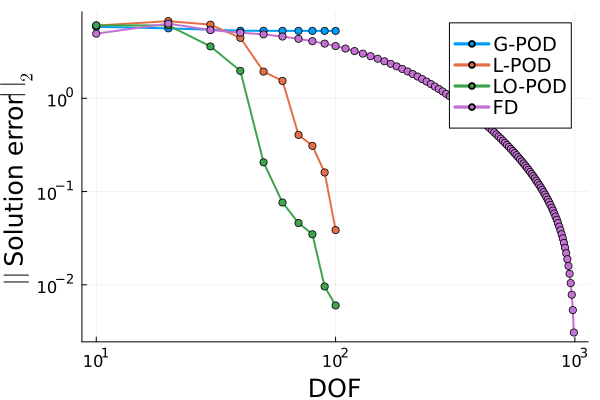

In [29]:
plot(10*collect(1:size(global_error)[1]),global_error,linewidth = 2,xscale = :log,marker = true,yscale = :log,label= "G-POD",xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
plot!(10*collect(1:size(local_error)[1]),local_error,linewidth = 2,marker = true,label = "L-POD")
plot!(10*collect(1:size(overlap_error)[1]),overlap_error,linewidth = 2,marker = true,label = "LO-POD")
plot!(10*collect(1:size(fd_error)[1]),fd_error,linewidth = 2,marker = true, label = "FD")
xlabel!("DOF")
ylabel!(L"||" *"Solution error"* L"||_2")
savefig("plots/DOF_vs_error.pdf")
plot!()

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots ~/.julia/packages/Plots/ju9dp/src/args.jl:1584


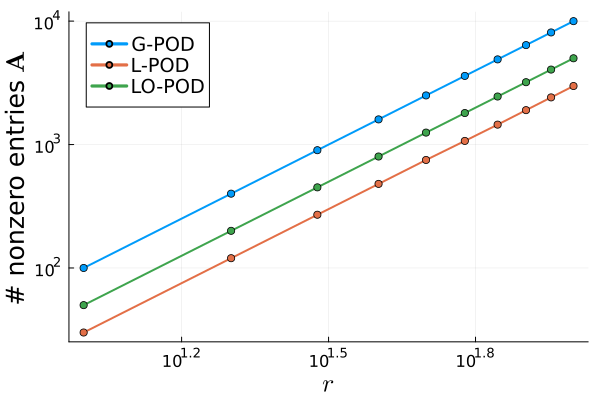

In [30]:
plot(10*collect(1:size(global_error)[1]),global_sparsity,linewidth = 2,marker = true,xscale = :log,yscale = :log,label= "G-POD",xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(17), 
    legendfont=font(13))
plot!(10*collect(1:size(local_error)[1]),local_sparsity,linewidth = 2,marker = true,label = "L-POD")
plot!(10*collect(1:size(overlap_error)[1]),overlap_sparsity,linewidth = 2,marker = true,label = "LO-POD")
xlabel!(L"r")
ylabel!("# nonzero entries " * L"\mathbf{A}")
savefig("plots/sparsity.pdf")
plot!()

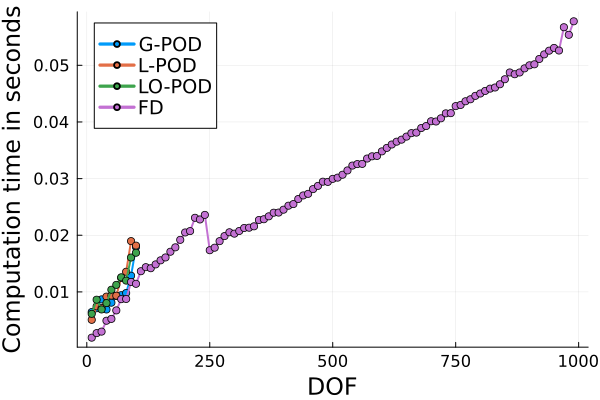

In [31]:
plot(10*collect(1:size(global_eval_times)[1]),global_eval_times,linewidth = 2,marker = true,label= "G-POD",xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(16), 
    legendfont=font(13))
plot!(10*collect(1:size(local_eval_times)[1]),local_eval_times,linewidth = 2,marker = true,label = "L-POD")
plot!(10*collect(1:size(overlap_eval_times)[1]),overlap_eval_times,linewidth = 2,marker = true,label = "LO-POD")
plot!(10*collect(1:size(fd_eval_times)[1]),fd_eval_times,linewidth = 2,marker = true, label = "FD")

xlabel!("DOF")
ylabel!("Computation time in seconds")
savefig("plots/DOF_vs_computation_time.pdf")
plot!()

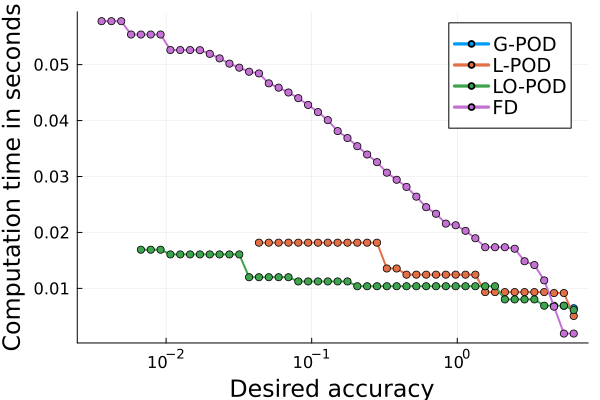

In [32]:
error_range = log10.(extrema(fd_error))
points = 50
eval_errs = 10 .^ (LinRange(error_range...,points)) ## Consider 50 points between the minimum and maximum error

errs = [global_error,local_error,overlap_error,fd_error]
eval_times = [global_eval_times,local_eval_times,overlap_eval_times,fd_eval_times]
err_times = [NaN * zeros(points) for i in errs]

for i in 1:size(errs)[1]
    lower = false
    for j in 1:size(eval_errs)[1]
        for k in 1:size(errs[i])[1]
            if isnan(err_times[i][j])
                if errs[i][k] <= eval_errs[j]
                    err_times[i][j] = eval_times[i][k]
                end
            else
                if eval_times[i][k] < err_times[i][j]
                    err_times[i][j] = eval_times[i][k]
                end
            end

        end
    end
    
end

labels = ["G-POD","L-POD","LO-POD","FD"]
plot(xscale = :log,xtickfont=font(11), 
    ytickfont=font(11), 
    guidefont=font(16), 
    legendfont=font(13))
for i in 1:size(labels)[1]
    plot!(eval_errs,err_times[i],label = labels[i],marker = true,linewidth = 2)
end

plot!()
xlabel!("Desired accuracy")
ylabel!("Computation time in seconds")
savefig("plots/accuracy_vs_computation_time.pdf")
plot!()